In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
from scipy.stats import gaussian_kde
import warnings
import matplotlib.colors as clr
import seaborn as sns
import re
import scipy.sparse as sp

warnings.filterwarnings("ignore")

In [2]:
adata = sc.read_h5ad('/mnt/sata1/Dhruv_Analysis_1/2025_10_31_Clone13/combined/final_adata.h5ad')

In [3]:
adata.obs.columns
adata.obs['Subtype'] = adata.obs['resolvi_predicted']
adata.obs['Subtype'].value_counts()


Subtype
Enterocyte_3             133844
Transit_Amplifying       107870
Early_Enterocyte         100620
Cd8_T-Cell_P14            39700
Myofibroblast             36860
T-Cell gd                 35709
Fibroblast                25032
Enterocyte_1              24823
Enterocyte_2              21294
Macrophage                19039
Monocyte                  18754
ILC                       15890
NK-Cell                   11001
MAIT                       9090
Cd4_T-Cell                 8033
Cd8_T-Cell_ab+             7938
B-Cell                     5837
Vascular Endothelial       5796
Fibroblast_Pdgfrb+         5050
Cd8_T-Cell_aa+             5040
Enteroendocrine            4995
cDC1                       3973
Lymphatic                  3572
Neuron                     3554
DC2                        3415
ISC                        3225
Resting Fibroblast         2504
Complement_Fibroblast      2393
Paneth                     2184
Fibroblast_Pdgfra+         2136
Tuft                       2031


In [4]:
zissou = [
    "#3A9AB2",
    "#6FB2C1",
    "#91BAB6",
    "#A5C2A3",
    "#BDC881",
    "#DCCB4E",
    "#E3B710",
    "#E79805",
    "#EC7A05",
    "#EF5703",
    "#F11B00",
]

colormap = clr.LinearSegmentedColormap.from_list("Zissou", zissou)
colormap_r = clr.LinearSegmentedColormap.from_list("Zissou", zissou[::-1])

In [5]:
def scatter_with_gaussian_kde(ax, x, y, **kwargs):
    """
    Plots a scatter plot colored by gaussian kde estimates.

    Parameters:
    - ax (matplotlib ax): The ax on which to plot the scatter plot.
    - x (np.array): The x values to perform the gaussian kde and scattering on.
    - y (np.array): The y values to perform the gaussian kde and scattering on.
    - **kwargs: Additional keyword arguments to pass to the scatter function.

    Returns:
    - None
    """

    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    ax.scatter(x, y, c=z, **kwargs)


# Custom biexponential transformation. Returns x coordinates that have been transformed
def transformation(x, a=0.1, b=0.1, c=0.5, d=2.5, f=4, w=1):
    x = np.array(x)
    return a * np.exp(b * ((x - w))) - c * np.exp(-d * (x - w)) + f


def draw_gates(ax, gates, transformation, type="edge"):
    """
    Draws IMAP gates on a matplotlib ax.

    Parameters:
    - ax (matplotlib ax): The ax on which to draw the gates.
    - gates (dict): A dictionary containing the gates to draw.
    - transformation (function): A function to transform the x values of the gates.
    - type (str): The type of gate to draw. Can be "fill" or "edge".

    Returns:
    - None
    """
    from matplotlib.patches import Polygon

    for gate in gates:
        # Apply transformation to x values
        points = [
            [transformation(element[0])] + element[1:]
            for element in gates[gate]["edges"]
        ]

        if type == "fill":
            p = Polygon(points, facecolor=gates[gate]["fill"], edgecolor="none")
            ax.add_patch(p)
        elif type == "edge":
            p = Polygon(points, facecolor="none", edgecolor="#222222")
            ax.add_patch(p)

            ax.text(
                transformation(gates[gate]["label_position"]["x"]),
                gates[gate]["label_position"]["y"],
                gate,
                fontsize=6,
                color="#222222",
            )


def classify_cells(adata, gates, transformation=transformation):
    """
    Classify cells based on the IMAP gates.

    Parameters:
    - adata (anndata): The anndata object containing the cells to classify.
    - gates (dict): A dictionary containing the gates to classify the cells with.
    - transformation (function): A function to transform the x values of the gates.

    Returns:
    - result (geopandas dataframe): A geopandas dataframe containing the classified cells.
    """
    from shapely.geometry import Point
    from shapely.geometry.polygon import Polygon
    import geopandas as gpd

    adata.obs["epithelial_distance_transformed"] = transformation(
        adata.obs["epithelial_distance"]
    )
    adata.obs["gate"] = False

    print("Creating polygons")
    polygons = {}
    for gate in gates:
        # Apply transformation to x values
        points = [
            [transformation(element[0])] + element[1:]
            for element in gates[gate]["edges"]
        ]
        polygons[gate] = Polygon(points)
    polygons = gpd.GeoSeries(polygons)
    gpd_poly = gpd.GeoDataFrame({"gates": polygons}, geometry="gates")

    print("Creating cells")
    cells = gpd.GeoSeries.from_xy(
        adata.obs["epithelial_distance_transformed"], adata.obs["crypt_villi_axis"]
    )
    gpd_cells = gpd.GeoDataFrame({"cells": cells}, geometry="cells")

    print("Joining cells and polygons")
    result = gpd.sjoin(
        gpd_cells,
        gpd_poly,
        how="left",
    )
    return result

Define IMAP gates

In [6]:
# Coordinates of the gates
gates = {
    "Top IE": {
        "edges": [
            [0.055, 0.555],
            [0.295, 0.555],
            [0.295, 1.03],
            [0.055, 1.03],
        ],
        "label_position": {"x": 0.1, "y": 0.9},
        "fill": "#3A9AB244",
        "stroke": "#3A9AB2",
    },
    "Crypt IE": {
        "edges": [
            [0.055, 0.545],
            [0.295, 0.545],
            [0.295, 0.15],
            [0.055, 0.15],
        ],
        "label_position": {"x": 0.1, "y": 0.3},
        "fill": "#F11B0044",
        "stroke": "#F11B00",
    },
    "Top LP": {
        "edges": [
            [0.305, 0.555],
            [6, 0.555],
            [6, 1.03],
            [0.305, 1.03],
        ],
        "label_position": {"x": 0.5, "y": 0.9},
        "fill": "#F0FEFF44",
        "stroke": "#F0FEFF",
    },
    "Crypt LP": {
        "edges": [
            [0.305, 0.545],
            [6, 0.545],
            [6, 0.295],
            [0.335, 0.15],
            [0.305, 0.15]
        ],
        "label_position": {"x": 0.5, "y": 0.3},
        "fill": "#F7DDDA44",
        "stroke": "#F7DDDA",
    },
    "Muscularis": {
        "edges": [
            [0.34, 0.15], 
            [6, 0.29], 
            [6, .15], 
        ],
        "label_position": {"x": 0.6, "y": 0.2},
        "fill": "#BDC88155",
        "stroke": "#BDC881",
    },
}

Plotting the IMAPs of P14s across batches

In [ ]:
# # Create subplots
# def plot_imaps(
#     adata,
#     batches,
#     obs,
#     values,
#     ax_ticks=[0.15, 0.3, 0.6, 1, 6],
#     transformation=transformation,
#     gates=gates,
#     dpi=600,
# ):
#     """
#     Plots IMAPs for a given set of batches and cells belonging to the categories in "values".

#     Parameters:
#     - adata (anndata): The anndata object containing the cells to plot.
#     - batches (list): A list of batches to plot.
#     - obs (str): The observation column from the adata to plot.
#     - values (list): Values in the observation column to subset the plotting to.
#     - ax_ticks (list): A list of x-axis ticks.
#     - transformation (function): A function to transform the x values of the gates.
#     - gates (dict): A dictionary containing the gates to plot.
#     - dpi (int): The dpi of the plot.

#     Returns:
#     - None
#     """

#     fig = plt.figure(figsize=(3 * len(values), 3 * len(batches)), dpi=dpi)

#     # Apply transformation
#     adata.obs["epithelial_distance_transformed"] = transformation(
#         adata.obs["epithelial_distance"]
#     )

#     for col, value in enumerate(values):
#         print("Plotting value: " + str(value))
#         # Iterate over batches
#         for i, bt in enumerate(batches):
#             sub_adata = adata[adata.obs["batch"] == bt]
#             sub_adata = sub_adata[sub_adata.obs[obs] == value]
#             ax = fig.add_subplot(len(batches), len(values), i * len(values) + 1 + col)

#             # Draw gates filled in background
#             draw_gates(ax, gates=gates, transformation=transformation, type="fill")

#             # Draw the density lines
#             sns.kdeplot(
#                 data=sub_adata.obs,
#                 x="epithelial_distance_transformed",
#                 y="crypt_villi_axis",
#                 ax=ax,
#                 color="#444444",
#                 linewidths=0.5,
#             )

#             # Colored scatter plot
#             scatter_with_gaussian_kde(
#                 ax=ax,
#                 x=sub_adata.obs["epithelial_distance_transformed"],
#                 y=sub_adata.obs["crypt_villi_axis"],
#                 s=5,
#             )

#             # Transform the tick labels and set them
#             ax.set_xticks(transformation(ax_ticks))
#             ax.set_xticklabels(ax_ticks)

#             # Label the axes
#             ax.set_xlabel("Epithelial Axis")
#             ax.set_ylabel(f"{bt}\nCrypt-Villi Axis")

#             ax.set_ylim(-0.02, 1.05)

#             # Add a title
#             if i == 0:
#                 ax.set_title(f"{value}")
#             else:
#                 ax.set_title(f"")
#             draw_gates(ax, gates=gates, transformation=transformation)

#     fig.tight_layout()

In [28]:
# Create subplots
def plot_imaps(
    adata,
    batches,
    obs,
    values,
    ax_ticks=[0.15, 0.3, 0.6, 1, 6],
    transformation=transformation,
    gates=gates,
    dpi=600,
):
    """
    Plots IMAPs for a given set of batches and cells belonging to the categories in "values".

    Parameters:
    - adata (anndata): The anndata object containing the cells to plot.
    - batches (list): A list of batches to plot.
    - obs (str): The observation column from the adata to plot.
    - values (list): Values in the observation column to subset the plotting to.
    - ax_ticks (list): A list of x-axis ticks.
    - transformation (function): A function to transform the x values of the gates.
    - gates (dict): A dictionary containing the gates to plot.
    - dpi (int): The dpi of the plot.

    Returns:
    - None
    """

    fig = plt.figure(figsize=(4, 3 * len(batches)), dpi=dpi)

    # Apply transformation
    adata.obs["epithelial_distance_transformed"] = transformation(
        adata.obs["epithelial_distance"]
    )

    # Iterate over batches
    for i, bt in enumerate(batches):
        sub_adata = adata[adata.obs["batch"] == bt]
        sub_adata = sub_adata[sub_adata.obs[obs].isin(values)]
        ax = fig.add_subplot(len(batches), 1, i + 1)


        # Draw gates filled in background
        draw_gates(ax, gates=gates, transformation=transformation, type="fill")

        # Draw the density lines
        sns.kdeplot(
            data=sub_adata.obs,
            x="epithelial_distance_transformed",
            y="crypt_villi_axis",
            ax=ax,
            color="#444444",
            linewidths=0.5,
        )

        # Colored scatter plot
        scatter_with_gaussian_kde(
            ax=ax,
            x=sub_adata.obs["epithelial_distance_transformed"],
            y=sub_adata.obs["crypt_villi_axis"],
            s=5,
        )

        # Transform the tick labels and set them
        ax.set_xticks(transformation(ax_ticks))
        ax.set_xticklabels(ax_ticks)

        # Label the axes
        ax.set_xlabel("Epithelial Axis")
        ax.set_ylabel(f"{bt}\nCrypt-Villi Axis")

        ax.set_ylim(-0.02, 1.05)

        # Add a title
        if i == 0:
            ax.set_title(" | ".join(values))
        else:
            ax.set_title(f"")
        draw_gates(ax, gates=gates, transformation=transformation)

    fig.tight_layout()

In [29]:
# Filter Xist positive cells

gidx = adata.var_names.get_loc('Xist')
X = adata.X
if sp.issparse(X):
    mask = X[:, gidx].toarray().ravel() > 0  # safe for sparse
else:
    mask = X[:, gidx] > 0

adata_xist = adata[mask].copy()
print(adata.obs.shape)
print(adata_xist.obs.shape)


(674090, 37)
(7422, 37)


In [30]:
batches = {
    'batch_1': {'x': 6200, 'y': 6200},
    'batch_2': {'x': 5800, 'y': 5500},
}

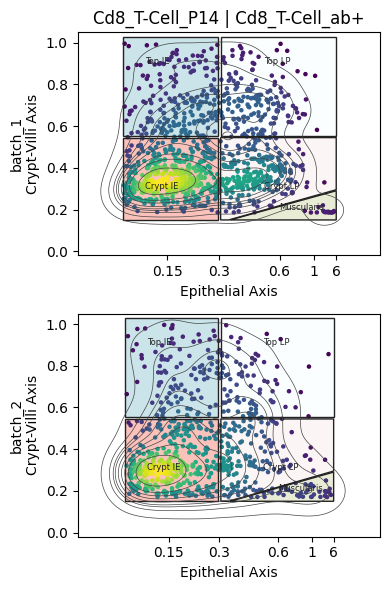

In [31]:
# p14s that express xist
plot_imaps(adata_xist, batches, obs="Subtype", values=["Cd8_T-Cell_P14", "Cd8_T-Cell_ab+"], dpi=100)

combine them ^

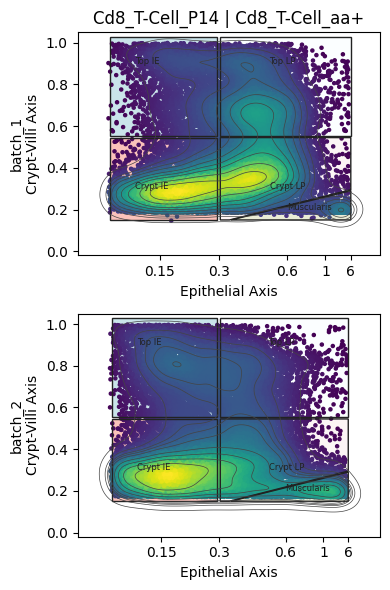

In [32]:
# not filtered for xist counts
plot_imaps(adata, batches, obs="Subtype", values=["Cd8_T-Cell_P14", "Cd8_T-Cell_aa+"], dpi=100)

Quantification of P14s in each gate

In [33]:
adata_p14 = adata[adata.obs["Subtype"] == "Cd8_T-Cell_P14"]

In [34]:
classification = classify_cells(adata_p14, gates)

adata_p14.obs["gate"] = classification["index_right"]
df = adata_p14.obs

df_abs = df.groupby(["batch", "gate"]).size().unstack()
df_abs["Day"] = [re.findall(r"\d+", index)[0] for index in df_abs.index]
df_abs

Creating polygons
Creating cells
Joining cells and polygons


gate,Crypt IE,Crypt LP,Muscularis,Top IE,Top LP,Day
batch,,,,,,
batch_1,6176,6400,872,1224,4451,1
batch_2,8144,5126,2129,1473,2605,2


Text(0.5, 1.0, 'Absolute cell numbers')

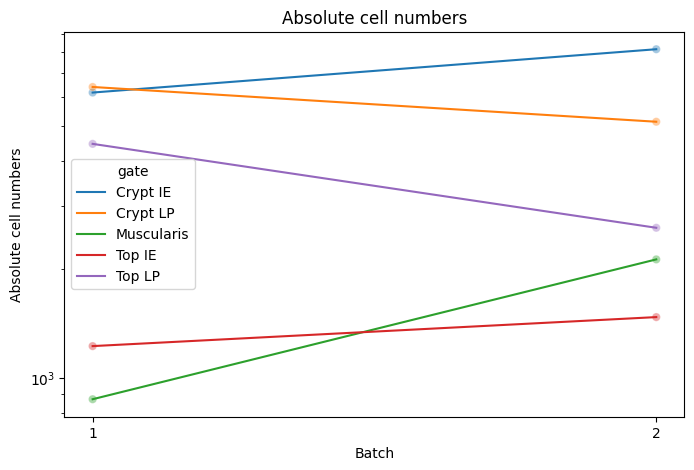

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))

sns_df = df_abs
sns_df = sns_df.set_index("Day")

sns.lineplot(sns_df, dashes=False, ax=ax)
sns.scatterplot(sns_df, ax=ax, markers="o", alpha=0.4, legend=False)
ax.set_yscale("log")
plt.xlabel("Batch")
plt.ylabel("Absolute cell numbers")
plt.title("Absolute cell numbers")